In [1]:
%config InlineBackend.figure_format = 'retina'
import os
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm; tqdm.pandas()
plt.style.use('seaborn')
cwd = os.getcwd()

from utility import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier, LGBMRegressor
import category_encoders as ce
import shap

/Users/frank/.venv/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/frank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/frank/.venv/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Read in data
post = pd.read_csv(cwd+'/data/post_metrics_and_comments.csv')
htag = pd.read_csv(cwd+'/data/hashtag_top_appearances.csv')
rawp = pd.read_csv(cwd+'/data/raw_post_metrics.csv')
print('post_metrics_and_comments.csv has {} rows and {} columns'.format(post.shape[0],post.shape[1]))
print('hashtag_top_appearances.csv has {} rows and {} columns'.format(htag.shape[0],htag.shape[1]))
print('raw_post_metrics.csv has {} rows and {} columns'.format(rawp.shape[0],rawp.shape[1]))

post_metrics_and_comments.csv has 11637 rows and 11 columns
hashtag_top_appearances.csv has 25062 rows and 2 columns
raw_post_metrics.csv has 70532 rows and 5 columns


In [9]:
post = post.merge(htag)
rawp = post.merge(rawp)

# Remove "|, @, #" in comments and translate into English
post['en_comment'] = post.concatenated_comments.progress_apply(process_comment)
print('Done Feature Engineering 1/10')
trans(post)
print('Done Feature Engineering 2/10')

# Calculate comments length and counts
post['comment_length'] = post.en_comment.progress_apply(len)
print('Done Feature Engineering 3/10')
post['comment_count'] = post.concatenated_comments.progress_apply(lambda x: x.count('|'))
print('Done Feature Engineering 4/10')

# Calculate emoji counts and emoji rates in comments
post['comment_emojicount'] = post.concatenated_comments.progress_apply(countemoji)
print('Done Feature Engineering 5/10')
post['comment_emojirate'] = post.comment_emojicount / (post.comment_length+1)

# Calculate average comments length
post['ave_comment_length'] = (post.comment_emojicount + post.comment_length)/(post.comment_count+1)

# Calculate comments sentiment score
post['comment_sentiment'] = post.en_comment.progress_apply(sentiment)
print('Done Feature Engineering 6/10')

# Calculate datetime and generate weekdays
post['weekday'] = post.date_posted.progress_apply(getweekday)
print('Done Feature Engineering 7/10')

# Calculate likes & comments per day
rawp['date_posted'] = rawp.date_posted.progress_apply(getdate1)
print('Done Feature Engineering 8/10')
rawp['date_time_collected'] = rawp.date_time_collected.progress_apply(getdate2)
print('Done Feature Engineering 9/10')
rawp['daydelta'] = rawp.date_time_collected - rawp.date_posted
rawp['daydelta'] = rawp['daydelta'].dt.days
rawp.num_likes = rawp.num_likes/rawp.max_likes
rawp.num_comments = rawp.num_comments/rawp.max_comments
rawp = rawp.dropna(subset=['num_likes', 'num_comments', 'daydelta'])
model = LGBMRegressor(random_state=0)
model.fit(rawp.daydelta.values.reshape(-1,1), rawp.num_likes)
rawp['perday_update'] = rawp.daydelta.progress_apply(lambda x: model.predict([[x]])[0])
print('Done Feature Engineering 10/10')
rawp = rawp.groupby(['post_url', 'max_likes', 'max_comments'], as_index=False)[['daydelta', 'perday_update']].max()
rawp = rawp[rawp.daydelta>=1]
rawp.loc[:,'likes_per_day'] = rawp.max_likes/rawp.daydelta
rawp.loc[:,'comments_per_day'] = rawp.max_comments/rawp.daydelta
rawp['likes_per_day'] = rawp.likes_per_day/rawp.perday_update
rawp['comments_per_day'] = rawp.comments_per_day/rawp.perday_update

post = rawp.merge(post)

# Calculate comments per likes for each posts
post['comments_likes_ratio'] = post.max_comments / (post.max_likes+1)

# Calculate posts per day
post_count = post[['username','date_posted']].groupby(['username'], 
            as_index=False).count().rename(columns={"date_posted": "post_counts"})
post = post.merge(post_count)
post['posts_frequency'] = post.post_counts / 26 # (from 4/1 to 4/26)

# Generate a classification target variable
post.loc[post.days_in_hashtag_top_section == 0 ,'trending'] = 0
post.loc[post.days_in_hashtag_top_section != 0 ,'trending'] = 1
post = post.reset_index().rename(columns={"index": "idx"})

# Generate image count
urls = list(post.img_urls.str.strip('{}'))
post['img_count'] = [(item.count(',')+1) for item in urls]

print('Done all Feature Engineering')

post.to_pickle("./post.pkl")


Done Feature Engineering 1/10



Done Feature Engineering 2/10



Done Feature Engineering 3/10



Done Feature Engineering 4/10



Done Feature Engineering 5/10



Done Feature Engineering 6/10



Done Feature Engineering 7/10



Done Feature Engineering 8/10



Done Feature Engineering 9/10



Done Feature Engineering 10/10
Done all Feature Engineering


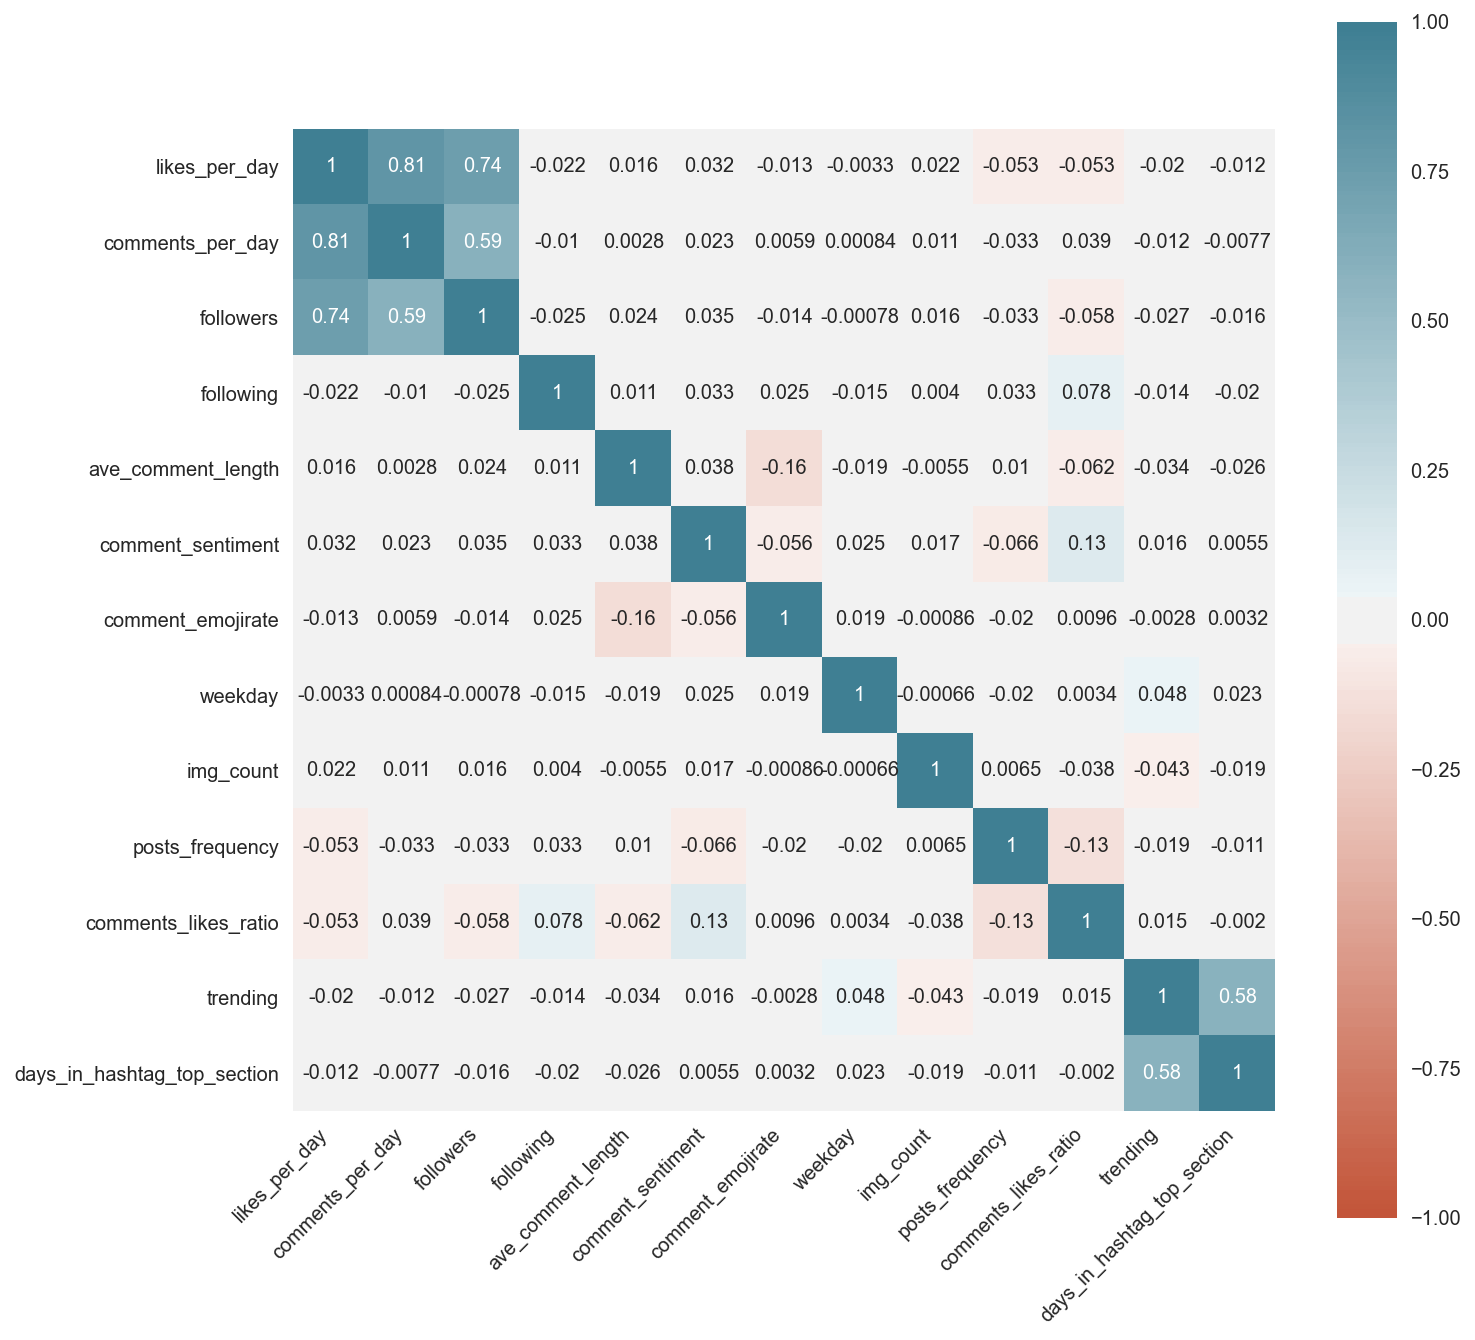

In [54]:
post = pd.read_pickle("./post.pkl")

data = post[['username', 'likes_per_day', 'comments_per_day', 'followers', 'following', 
             'ave_comment_length', 'comment_sentiment', 'comment_emojirate', 'weekday', 'img_count',
             'posts_frequency', 'comments_likes_ratio', 'trending', 'days_in_hashtag_top_section']]
# Plotting correlation matrix
fig = plt.figure(figsize=(11, 11))
ax = sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### Classification

In [55]:
data = data[['username', 'likes_per_day', 'comments_per_day', 'followers', 'following', 
             'ave_comment_length', 'comment_sentiment', 'weekday', 'comment_emojirate', 
             'trending', 'posts_frequency', 'comments_likes_ratio', 'img_count']]

X = data.drop(columns=['trending'])
y = data['trending']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Target Encoder
encoder = ce.TargetEncoder(cols=['username'])
# Make sure to use only training data to train the encoder
X_trainec = encoder.fit_transform(X_train, y_train)
X_testec = encoder.transform(X_test)
X_ec = encoder.transform(X)

SS = StandardScaler()
X_trainec_norm = pd.DataFrame(data = SS.fit_transform(X_trainec), columns = X.columns)
X_testec_norm = pd.DataFrame(data = SS.transform(X_testec), columns = X.columns)
X_ec_norm = pd.DataFrame(data = SS.transform(X_ec), columns = X.columns)

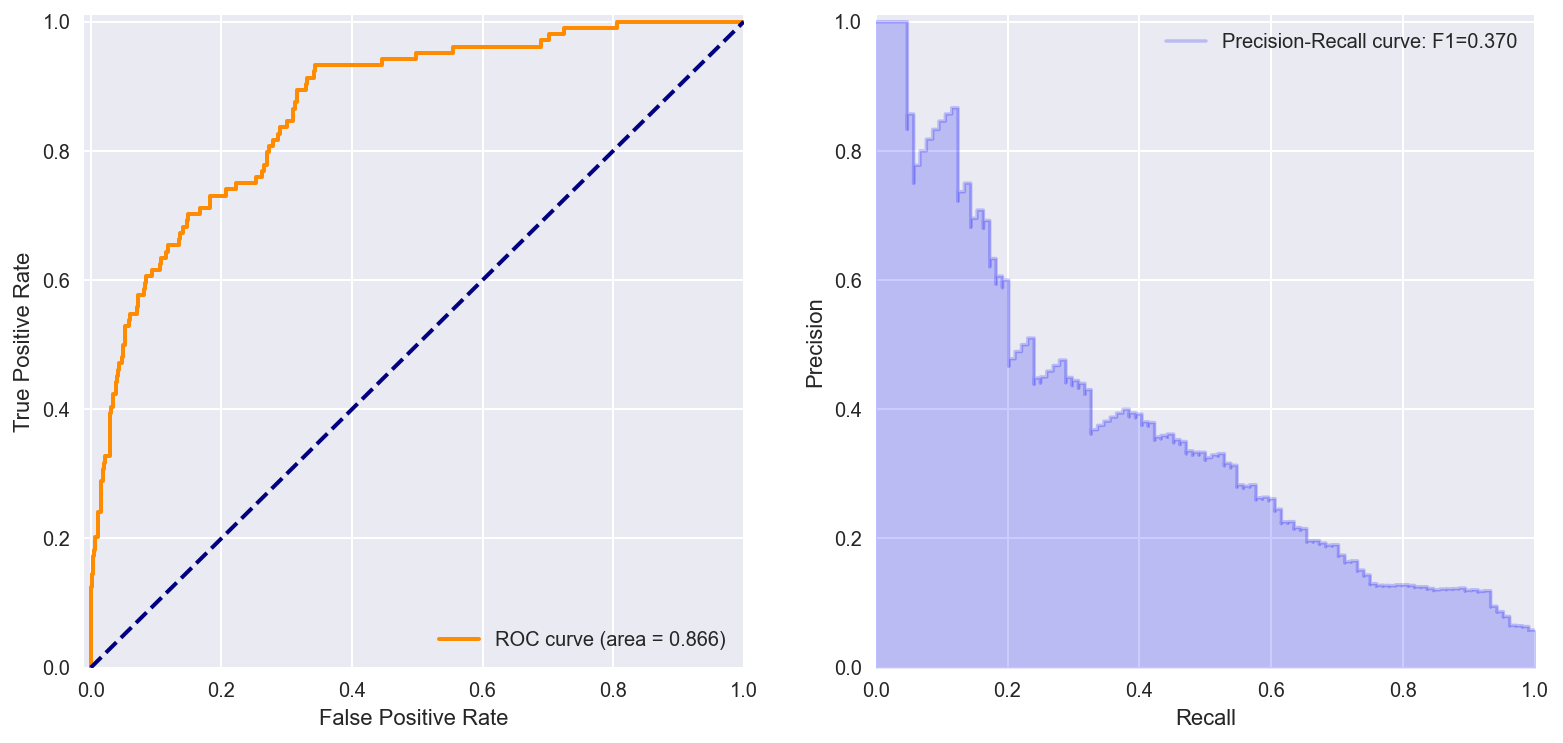

In [64]:
# Using grid search to tune the model
param = {'learning_rate': 0.1,
         'max_depth': 5,
         'min_child_samples': 8,
         'num_leaves': 32,
         'reg_alpha': 0,
         'reg_lambda': 0.6,
         'class_weight': 'balanced'}
lgbm = LGBMClassifier(**param, n_jobs = -1, random_state=0)
y_pred = lgbm.fit(X_trainec_norm, y_train).predict_proba(X_testec_norm).T[1]
fig = plt.figure(figsize=(13, 6))
plot_curves(y_test, y_pred)

In [65]:
shap.initjs()
explainer = shap.TreeExplainer(lgbm)
shap_values = np.array(explainer.shap_values(X_trainec_norm))
IMP = pd.DataFrame({'Feature': X.columns.values,
    'Importance': np.absolute(shap_values[1]).mean(axis = 0)}).sort_values(by = 'Importance', ascending = False)
IMP

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


,Feature,Importance
0,username,2.382384
2,comments_per_day,0.431287
11,img_count,0.402756
1,likes_per_day,0.289269
3,followers,0.247436
6,comment_sentiment,0.227455
5,ave_comment_length,0.204756
7,weekday,0.139073
8,comment_emojirate,0.118592
4,following,0.105628


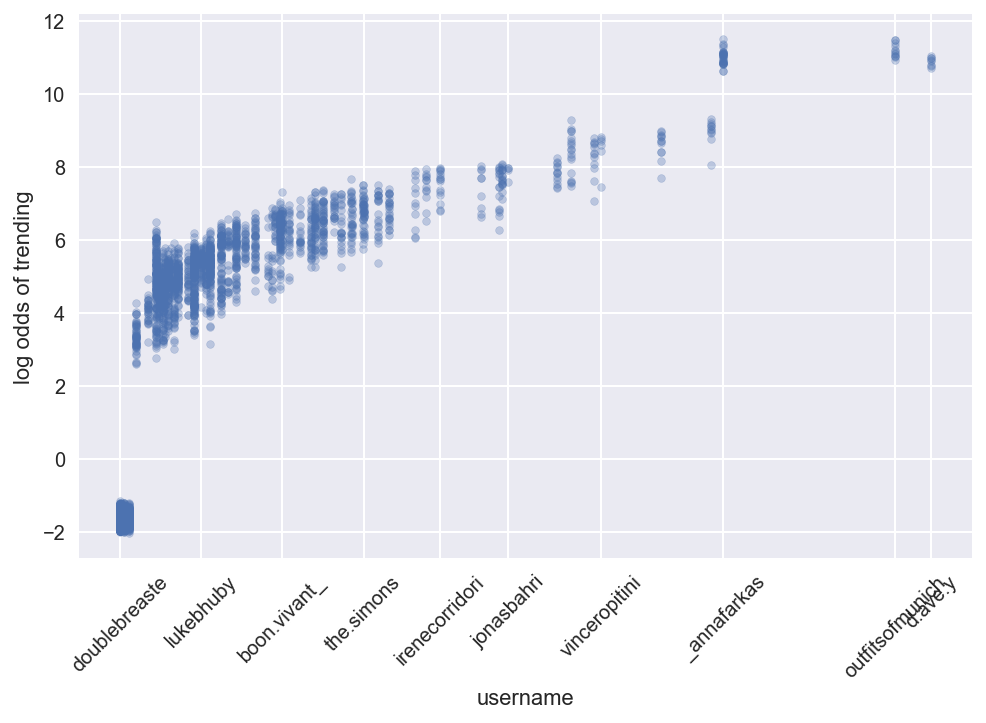

In [11]:
t = pd.DataFrame({'feat':X_trainec.username, 
                  'shap':shap_values[1].T[0]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
sample_idx = findindex(X_trainec, [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1])
plt.xticks(X_trainec.username[sample_idx], X_train.username[sample_idx], rotation = 45)
plt.xlabel('username'); plt.ylabel('log odds of trending')
plt.show()

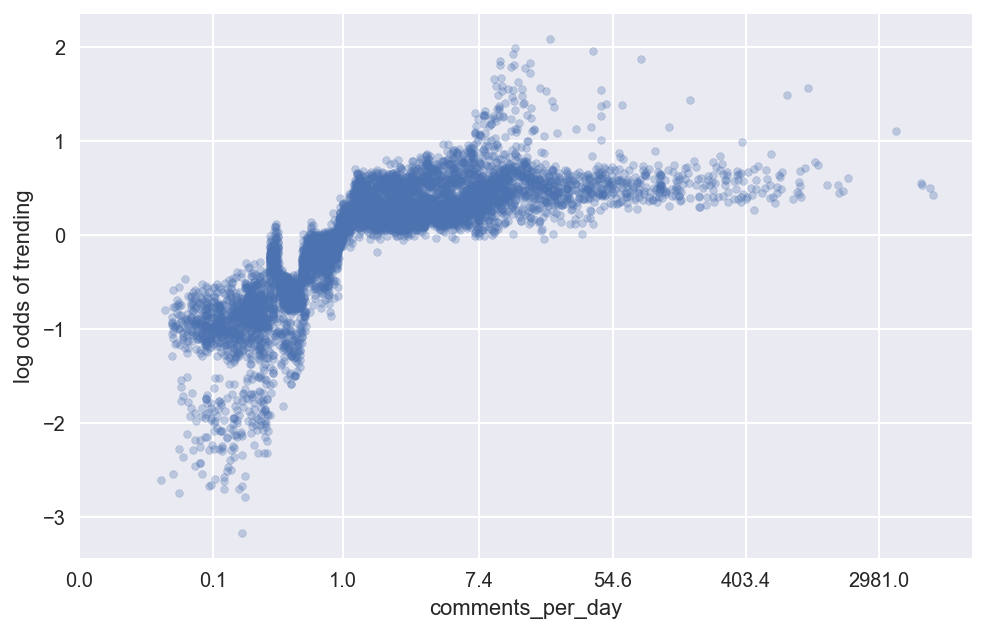

In [25]:
t = pd.DataFrame({'feat':np.log(X_trainec.comments_per_day), 
                  'shap':shap_values[1].T[2]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
ticks = [-4, -2,-0.05,2,4,6,8]
plt.xticks(ticks, np.round(np.exp(ticks),1))
plt.xlabel('comments_per_day'); plt.ylabel('log odds of trending')
plt.show()

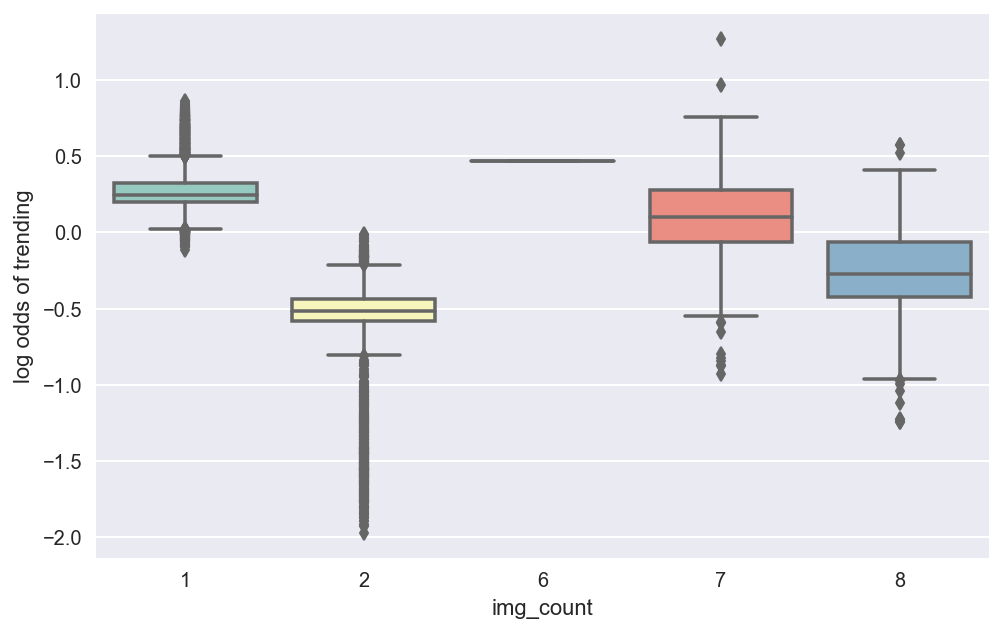

In [69]:
t = pd.DataFrame({'feat':X_trainec.img_count, 
                  'shap':shap_values[1].T[11]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
sns.boxplot(t.feat, t.shap, palette='Set3')
plt.xlabel('img_count'); plt.ylabel('log odds of trending')
plt.show()

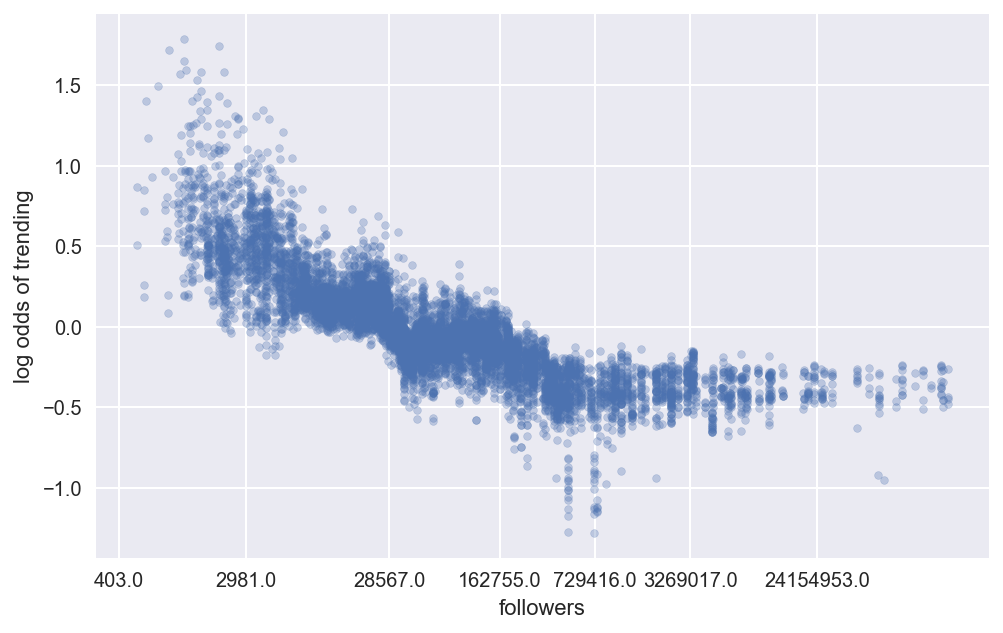

In [70]:
t = pd.DataFrame({'feat':np.log(X_trainec.followers), 
                  'shap':shap_values[1].T[3]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
ticks = [6,8,10.26,12,13.5,15,17]
plt.xticks(ticks, np.round(np.exp(ticks)))
plt.xlabel('followers'); plt.ylabel('log odds of trending')
plt.show()

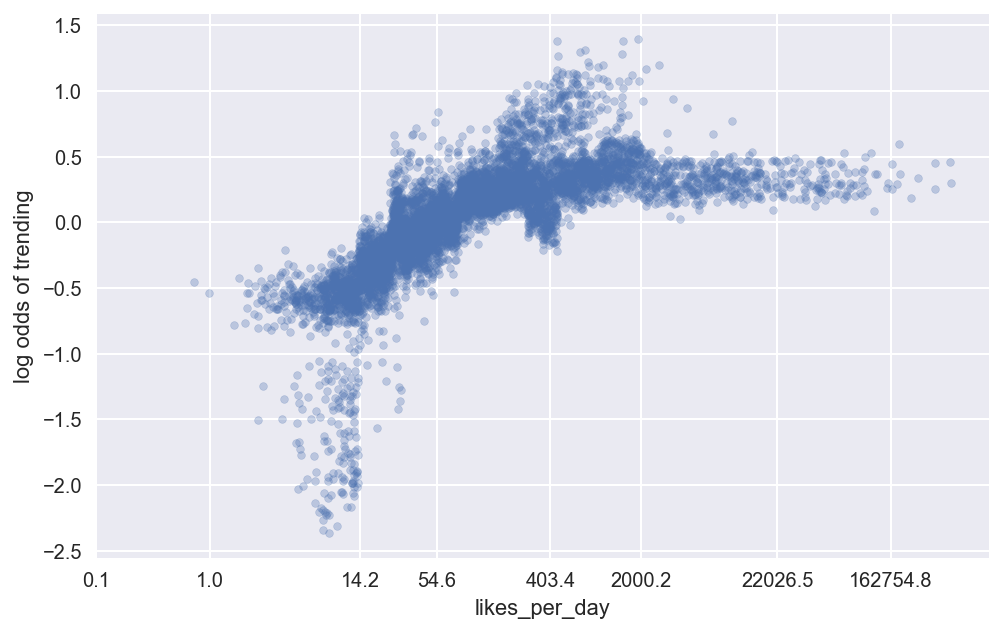

In [71]:
t = pd.DataFrame({'feat':np.log(X_trainec.likes_per_day+0.135), 
                  'shap':shap_values[1].T[1]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
ticks = [-2,0,2.65,4,6,7.601,10,12]
plt.xticks(ticks, np.round(np.exp(ticks),1))
plt.xlabel('likes_per_day'); plt.ylabel('log odds of trending')
plt.show()

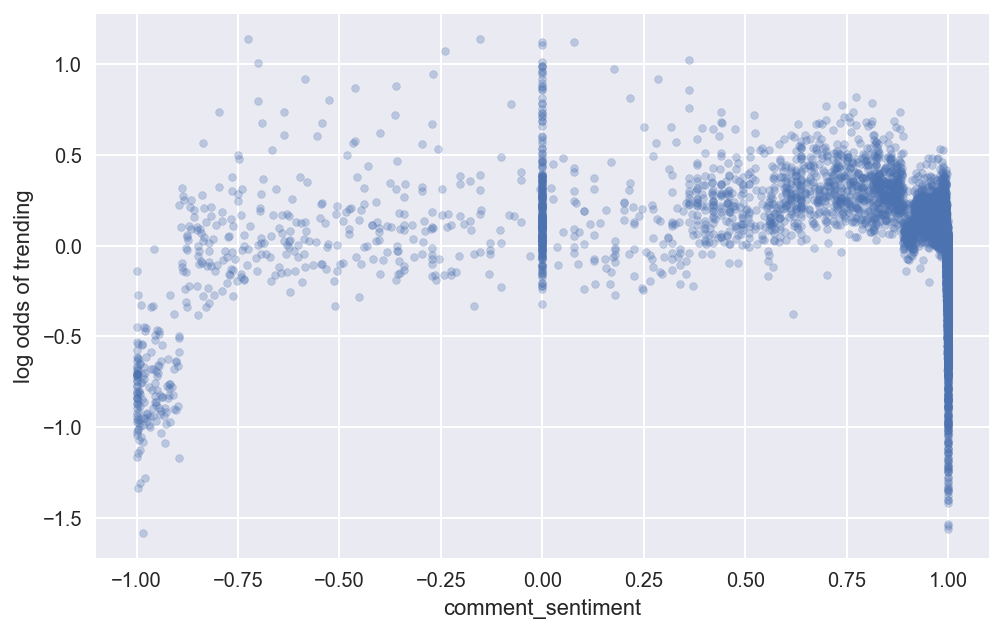

In [72]:
t = pd.DataFrame({'feat':X_trainec.comment_sentiment, 
                  'shap':shap_values[1].T[6]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
plt.xlabel('comment_sentiment'); plt.ylabel('log odds of trending')
plt.show()

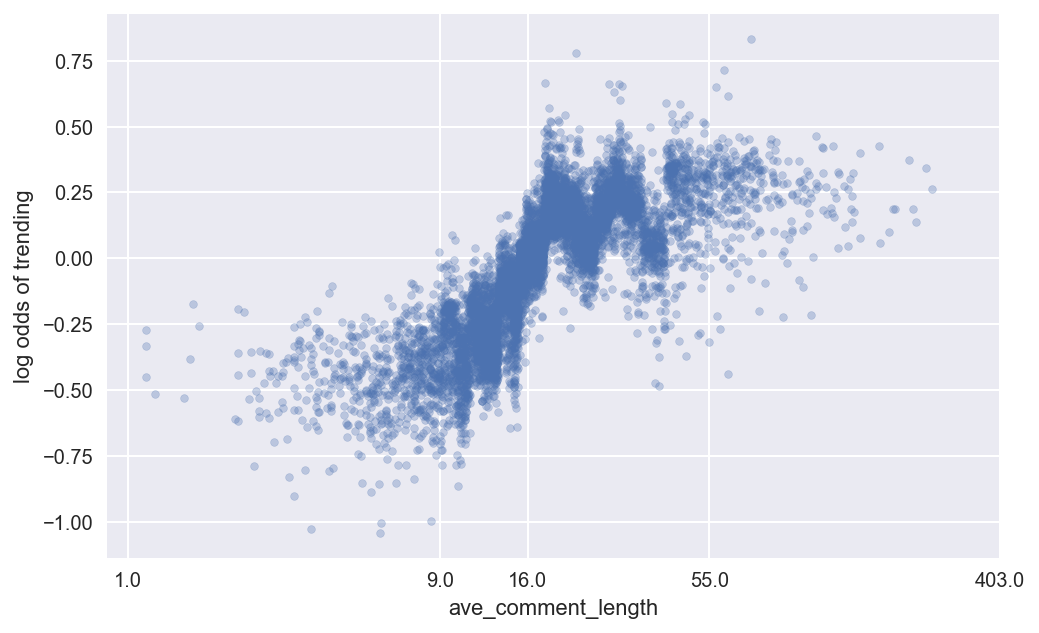

In [73]:
t = pd.DataFrame({'feat':np.log(X_trainec.ave_comment_length+0.135), 
                  'shap':shap_values[1].T[5]})
fig = plt.figure(figsize=(8, 5))
#plt.subplot(221)
plt.scatter(t.feat, t.shap, alpha = 0.3, s = 15)
ticks = [0,2.15,2.75,4,6]
plt.xticks(ticks, np.round(np.exp(ticks)))
plt.xlabel('ave_comment_length'); plt.ylabel('log odds of trending')
plt.show()

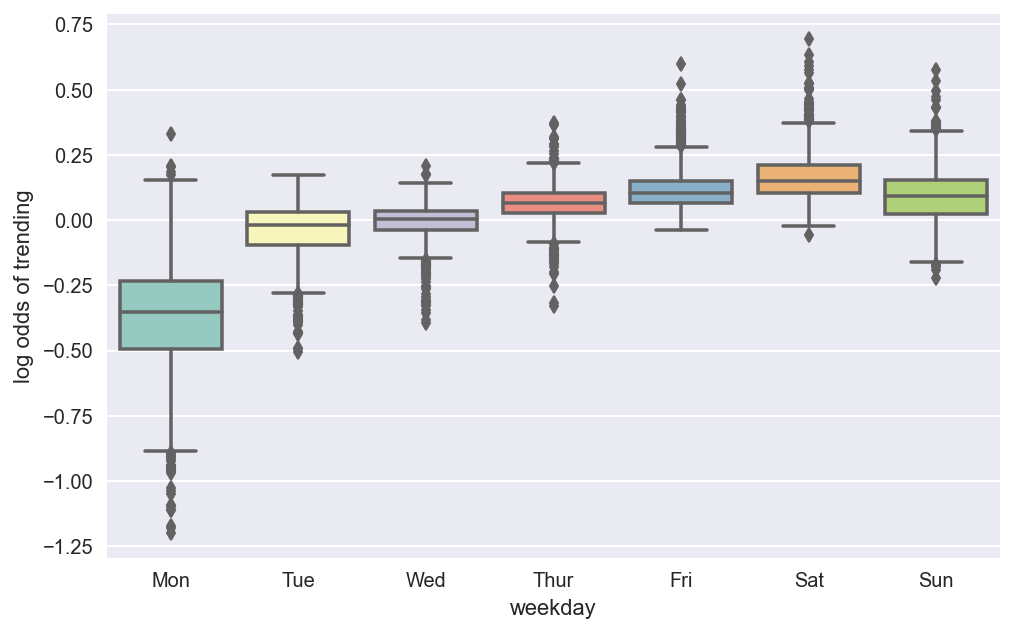

In [74]:
t = pd.DataFrame({'feat':X_trainec.weekday, 
                  'shap':shap_values[1].T[7]})
fig = plt.figure(figsize=(8, 5))
sns.boxplot(t.feat, t.shap, palette='Set3')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday'); plt.ylabel('log odds of trending')
plt.show()

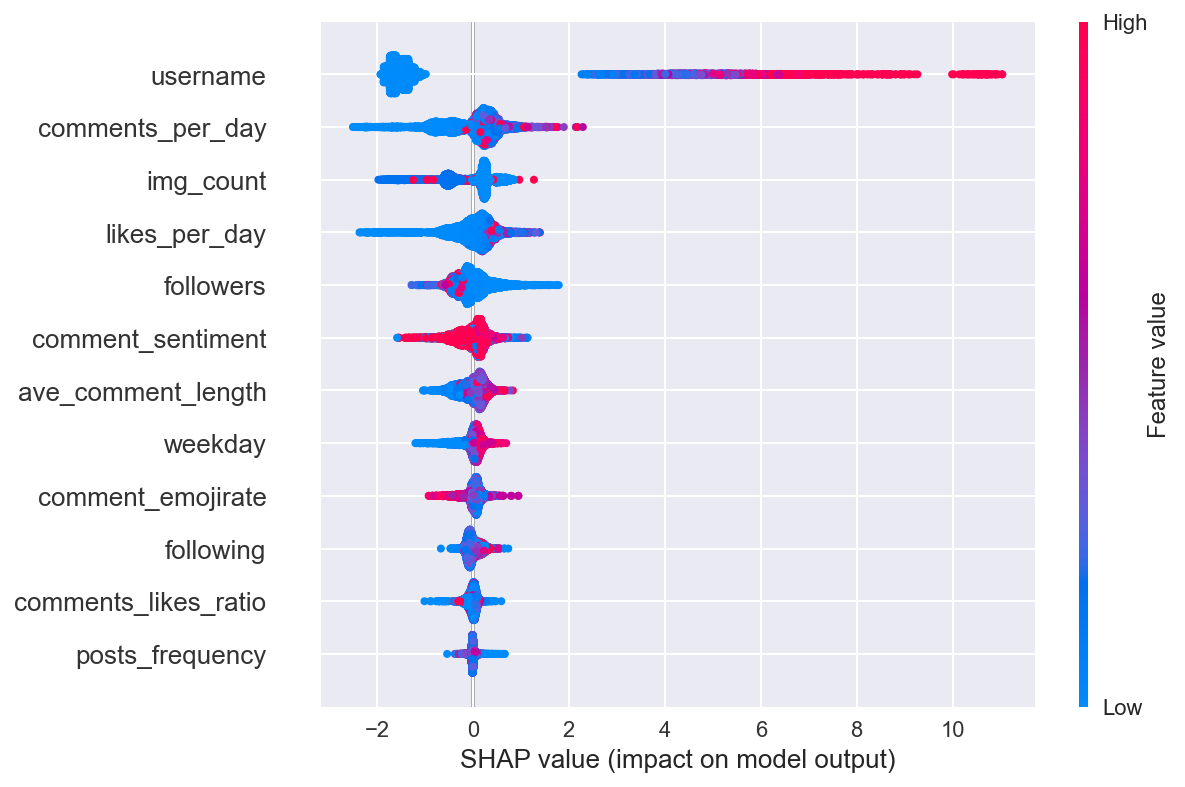

In [75]:
shap.summary_plot(shap_values[1], X_trainec)

In [76]:
post['pred'] = lgbm.predict_proba(X_ec_norm).T[1]
post.sort_values(by = 'pred', ascending = False)\
    [['post_url', 'username', 'likes_per_day', 'comments_per_day', 'daydelta',
      'followers', 'ave_comment_length', 'comment_sentiment', 'comment_emojirate', 
      'weekday', 'posts_frequency', 'comments_likes_ratio', 'days_in_hashtag_top_section']].head(10)

,post_url,username,likes_per_day,comments_per_day,daydelta,followers,ave_comment_length,comment_sentiment,comment_emojirate,weekday,posts_frequency,comments_likes_ratio,days_in_hashtag_top_section
10754,https://www.instagram.com/p/B_XUYo4KZN3/,outfitsofmunich,145.110298,1.999551,4,1037,13.666667,0.8074,0.185714,4,0.230769,0.013752,5
10935,https://www.instagram.com/p/B_ajoxYo_t8/,jason.kural,42.710248,2.396087,17,1156,9.333333,0.9912,0.201835,5,0.076923,0.056022,2
10660,https://www.instagram.com/p/B_XdCntH7QU/,kauzenshop,300.719796,3.783704,18,61200,48.944444,-0.7893,0.008584,4,0.076923,0.012580,4
10756,https://www.instagram.com/p/B_ahhGTKWPW/,outfitsofmunich,137.112093,3.427802,4,1037,26.214286,0.9854,0.069767,6,0.230769,0.024948,6
10753,https://www.instagram.com/p/B_VFXPjKaZB/,outfitsofmunich,695.287590,5.562301,1,1037,15.800000,0.6461,0.142857,3,0.230769,0.007984,2
10977,https://www.instagram.com/p/B_Zuf1AHDUe/,peipay97,36.420520,1.617359,17,1428,9.666667,0.9858,0.207469,5,0.076923,0.044335,1
10943,https://www.instagram.com/p/B_aHtncgiqY/,nur.rr,69.965736,29.651575,17,5577,17.837838,0.9990,0.107293,5,0.076923,0.423439,1
10942,https://www.instagram.com/p/B_StSIwgtB3/,nur.rr,55.804874,29.472266,20,5577,14.941860,0.9985,0.120209,2,0.076923,0.527652,2
10913,https://www.instagram.com/p/B_Zx7y2D7nF/,postuzapas,777.949496,3.294619,17,494000,19.000000,0.7530,0.176201,5,0.115385,0.004235,4
10958,https://www.instagram.com/p/B_X1YtqKVOD/,biggerswoosh,25.299994,0.621205,18,1295,26.166667,0.9552,0.022727,4,0.076923,0.024499,2


In [77]:
post[post.trending == 0].sort_values(by = 'pred', ascending = False)\
    [['post_url', 'username', 'likes_per_day', 'comments_per_day', 'daydelta',
      'followers', 'ave_comment_length', 'comment_sentiment', 'comment_emojirate', 
      'weekday', 'posts_frequency', 'comments_likes_ratio', 'days_in_hashtag_top_section', 'pred']].head(10)

,post_url,username,likes_per_day,comments_per_day,daydelta,followers,ave_comment_length,comment_sentiment,comment_emojirate,weekday,posts_frequency,comments_likes_ratio,days_in_hashtag_top_section,pred
4730,https://www.instagram.com/p/B-zYrB1jty9/,urbanculturs,377.629304,2.220981,32,167000,27.044444,0.6553,0.015000,4,0.692308,0.005881,0,0.996437
8488,https://www.instagram.com/p/B_LQRtjJGey/,squardes_,44.606625,0.350199,23,25000,20.818182,0.8856,0.045455,6,0.807692,0.007843,0,0.988490
4959,https://www.instagram.com/p/B-j285oordC/,pierre.laurent,192.748853,2.516649,38,86600,10.676471,0.9984,0.158902,5,0.692308,0.013055,0,0.970848
8447,https://www.instagram.com/p/B_IM6oQJkaz/,lessiswore,355.220582,3.762487,24,149000,10.825243,0.9863,0.205184,5,1.115385,0.010591,0,0.969600
10702,https://www.instagram.com/p/B_KyWA5A5if/,lessisworefemales,295.436810,1.357022,23,98500,14.818182,0.9919,0.111111,6,0.538462,0.004593,0,0.965822
10117,https://www.instagram.com/p/B_IRAdCJj8W/,unreap,395.019334,1.588606,24,181000,19.400000,0.9554,0.044856,5,0.961538,0.004021,0,0.965548
9692,https://www.instagram.com/p/B-jdr6vpeKF/,yoshihitomayo,483.382121,17.854965,38,199000,20.484472,0.9996,0.039382,5,0.153846,0.036936,0,0.960854
4085,https://www.instagram.com/p/B-111jxJ3_h/,drownedinreverb,31.349497,2.009999,31,17700,19.226667,0.9995,0.064159,5,0.653846,0.064050,0,0.956803
8648,https://www.instagram.com/p/B-xTxQtCq-V/,ckmhd,98.525066,3.668324,33,16400,16.672727,0.9822,0.092857,3,0.230769,0.037221,0,0.952230
7297,https://www.instagram.com/p/B-zLMowqUOI/,chris_rtk,40.353032,1.501508,32,4068,21.263158,0.9833,0.097693,4,0.461538,0.037180,0,0.947893
